# Adaboost Demonstration

### Adaboost Algorithm

Adaboost (i.e Adaptive Boosting) is an ensemble method that combines many weak classifiers to build strong classifiers with better accuracy. The basic idea is as under:

1. We select a base classifier (i.e weak classifier) such as Decision Tree and assign each of the 'N' data points a weight **w =1/n**
2. We classify the data using the weak classifier.
3. The data points that are misclassified by the weak classifier get a higher weight.
4. We update all the weights
5. The next iteration of classification puts more effort in classifying the data points that were misclassified in the previous iteration.
6. We iterate a pre-configured number of times and prepare the final model.

### Example Scenario

_Imagine that we need to conduct **Sentiment Analysis** on Twitter data where the objective is to ascertain overall sentiment of a given Tweet as **"Positive"** or **"Negative"**. How can AdaBoost help?_

_Please note that this demonstration is a simplified version of Sentiment Analysis problem and is only to be used as a demonstration of AdaBoost algorithm._

Let us use a DecisionTree classifier as a class of weak classifiers and combine them using AdaBoost. Mathematically our problem can then be written as combining **M** decision trees and at each iteration finding the predicted sentiment (i.e Positive or Negative) as sign of the  weighted sum of individual decision trees.

Assume that we have a set of **M** DecisionTree classifiers Dt.

$$ Dt_n \in \{Dt_1,Dt_2,...,Dt_m\}$$

then final decision for a given Tweet will be the sign of a function that combines sentiment class predicted by individual Decision Tree classifiers: 

 If the sentiment class predicted by a single decision tree x is given by a function.
 
 $$y= Dt_x(Tweet)$$ 
 where $$y \in \{+1, -1\}$$ 

then the final output would be :

   $$Sentiment = sign(\alpha_1Dt_1(Tweet)+\alpha_2Dt_2(Tweet)+...+\alpha_MDt_M(Tweet))$$
   
 
 The alpha is a weight computed on every iteration as a function of weights assigned to data points. Higher weight is assigned to the tweets that are misclassified so that the next DecisionTree classifier focuses on this data point more.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


In [2]:
def sentiment_test(tweet, model, vectorizer):
    """
    Description: Determines the overall sentiment of a Tweet as positive or negative
    Arguments:
        tweet: Tweet text
        model: Learned Model
        vectorizer: Vectorizer used in learning
    """
    transformed = vectorizer.transform(tweet)
    prediction = model.predict(transformed)
    if(prediction == -1):
        print('The overall sentiment of the tweet is : Negative')
        
    else:
        print('The overall sentiment of the tweet is : Positive')

##### Load Twitter Data

In [3]:
#Read Sentiment140 data from the CSV file
df = pd.read_csv("Tweets.csv")
df.head()

,ID,SentimentClass,SentimentText
0,0,-1,is so sad for my APL frie...
1,1,-1,I missed the New Moon trail...
2,2,1,omg its already 7:30 :O
3,3,-1,.. Omgaga. Im sooo im gunna CRy. I'...
4,4,-1,i think mi bf is cheating on me!!! ...


(-1.123812461198632,
 1.0093846825556887,
 -1.0048358694206503,
 1.0201710458629023)

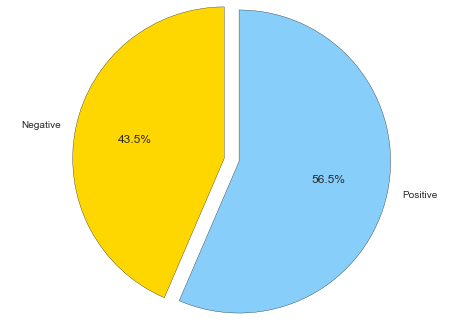

In [4]:
#Check the distribution of class labels
counts = df.SentimentClass.value_counts()
sizes = [(counts.loc[-1]/len(df.SentimentClass))*100,(counts.loc[1]/len(df.SentimentClass))*100]
labels = ['Negative','Positive']
colors = ['gold','lightskyblue']
plt.pie(sizes, explode=(0.1,0), labels=labels, colors=colors,
         autopct='%1.1f%%',shadow=False, startangle=90)
plt.axis('equal')


#####  Feature Extraction

In [5]:
#Feature Extraction
y=df.SentimentClass
X=df.SentimentText
#Split data in training and testing
Xtrain, Xtest, ytrain, ytest = train_test_split(X.values,y.values,test_size=0.3)
#Vectorization
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(Xtrain)
#Using the same vectorizer we vectorize the test data
X_test_vec = vectorizer.transform(Xtest)

In [6]:
#Check if the Vectorization is alright
print(vectorizer.vocabulary_.get(u'is'))

56339


##### Decision Tree Classifier

In [7]:
# Learn a model using Decision Tree
# Please note that we are not using GridSearchCV or any other cross validation
# intentionally to keep DecisionTree a weak classifier

learner = DecisionTreeClassifier(max_depth=5)
model = learner.fit(X_train_vec,ytrain)
#Model Evaluation using Test Data
y_predicted = model.predict(X_test_vec)

#Check Accuracy
score = roc_auc_score(ytest, y_predicted)
print("Area Under the ROC Curve using Weak Classifier is:   %0.3f" % score)


Area Under the ROC Curve using Weak Classifier is:   0.561


##### Test Decision Tree Classifier 

In [8]:
sentiment_test(["@This is awesome"],model,vectorizer)

The overall sentiment of the tweet is : Positive


##### AdaBoost Ensemble

In [9]:
#Create AdaBoost Classifier
adaboost_learner = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=200)
adaboost_model = adaboost_learner.fit(X_train_vec,ytrain)
#Model Evaluation using Test Data
y_predicted = adaboost_model.predict(X_test_vec)
#Check Accuracy
score = roc_auc_score(ytest, y_predicted)
print("Area Under the ROC Curve using AdaBoost is:   %0.3f" % score)

Area Under the ROC Curve using AdaBoost is:   0.734


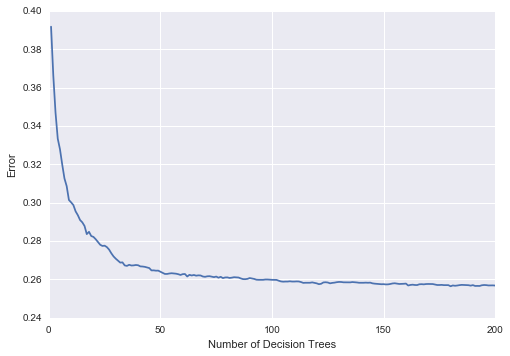

In [10]:
#Plot Errors against number of iterations
test_errors=[]
for test_prediction in adaboost_model.staged_predict(X_test_vec):
    test_errors.append(1. - accuracy_score(test_prediction,ytest))
plt.plot(range(1,len(adaboost_model)+1),test_errors)
plt.ylabel('Error')
plt.xlabel('Number of Decision Trees')

##### Test Adaboost

The overall sentiment of the tweet is : Negative


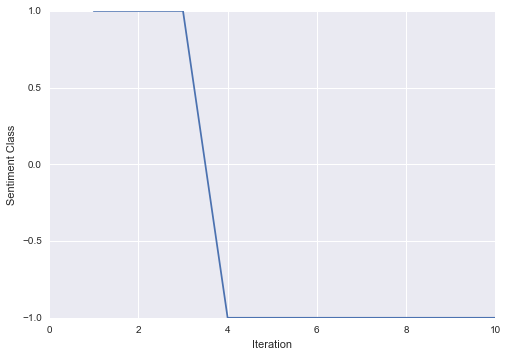

In [12]:
Tweet = "@This is bad"
sentiment_test([Tweet],adaboost_model,vectorizer)

#Plot iteration against the class decision
staged_predictions_generator = adaboost_model.staged_predict(vectorizer.transform([Tweet]))
class_labels=[]
for stage_prediction in staged_predictions_generator:
    class_labels.append(stage_prediction)

plt.plot(range(1,len(adaboost_model)+1),class_labels)
#plt.title("Prediction for ",Tweet)
plt.xlabel("Iteration")
plt.ylabel("Sentiment Class")
plt.xlim(0,10)
plt.show()

##### Conclusion
Adaptive Boosting is an effective ensemble method that can significantly improve the classification performance.

**References**

The Tweets data used in demonstration is derived from the Sentiment140 dataset available at:

http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

